## 1.加载依赖包

In [1]:
import numpy as np
import pandas as pd
import joblib
import warnings
import gc
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

## 1. 使用feature score 做特征筛选

In [53]:
def load_train(train_no=1):
    input_dir = '../../2.1preprocess_train_data/9.select_features/train_data/'
    train = joblib.load(input_dir+'train_0%d.lz4'%train_no) 
    y_train = train[['RULR']]
    x_train = train.drop(columns=['RULR'])
    return x_train, y_train

x_train_01, y_train_01 = load_train(1)
x_train_02, y_train_02 = load_train(2)
x_train_03, y_train_03 = load_train(3)

x_train = pd.concat([x_train_01, x_train_02, x_train_03], axis=0)
y_train = pd.concat([y_train_01, y_train_02, y_train_03], axis=0)

In [54]:
# 1.不做特征选择
use_cols = [col for col in x_train.columns if col not in ['CL']]

In [55]:
# 2.使用学习器做特征选择
from xgboost.sklearn import XGBRegressor
params = {'maxdepth': 6, 'learning_rate': 0.1, 'n_estimators': 100, 'objective': 'reg:linear',
         'booster': 'gbtree', 'n_jobs': 20, 'reg_lambda': 2}

xgb = XGBRegressor(**params)
xgb.fit(x_train, y_train)
joblib.dump(xgb, 'xgb_model')

xgb = joblib.load('./xgb_model')
feature_score = pd.Series(data = xgb.feature_importances_, index = x_train_01.columns).sort_values(ascending=False)
use_cols = list(feature_score[feature_score>0].index)
use_cols = [i for i in use_cols if 'CL'  not in i]
joblib.dump(use_cols, './use_cols')

['./use_cols']

In [56]:
use_cols = joblib.load('./use_cols')
use_cols

['Current_1__length',
 'Vibration_3__mean',
 'spindle_load',
 'Vibration_1__abs_energy_scale',
 'Vibration_3__abs_energy_scale',
 'Vibration_3__abs_energy',
 'Vibration_3__kurtosis',
 'Current_1__variance',
 'Vibration_3__mean_abs_change',
 'Vibration_2__abs_energy',
 'Current_1__mean_abs_change',
 'Vibration_1__variance',
 'Current_1__abs_energy_scale',
 'Current_1__abs_energy',
 'Vibration_2__kurtosis',
 'Vibration_2__variance',
 'Vibration_2__mean_abs_change']

## 2.去除异常点

In [18]:
# 加载baseline data
def load_train_baseline(train_nos=[1], use_cols=[]):
    '''
    描述:
        返回健康数据
    '''
    input_dir = '../../2.1preprocess_train_data/9.select_features/train_data/'
    train_list = []
    for i in train_nos:
        train = joblib.load(input_dir+'train_0%d.lz4'%i)
        train_list.append(train[:8000])
    train_baseline = pd.concat(train_list, axis=0)    
    train_baseline.reset_index(drop=True, inplace=True) 
    y_train_baseline = train_baseline[['RULR']]
    x_train_baseline = train_baseline[use_cols]
    return x_train_baseline, y_train_baseline  

x_train_baseline, y_train_baseline = load_train_baseline([1,2,3], use_cols)

In [32]:
# 数据标准化
# <1>定义baseline数据标准化函数
def standard_scale(x):
    if x.shape[0]==0:
        return x,0,0
    idx = x.index
    m = x.mean()
    std = x.std()
    scaler = StandardScaler()
    scaler.fit(x)
    x_arr = scaler.transform(x)
    return pd.DataFrame(x_arr, index = idx, columns =x.columns),scaler

# <2>使用健康数生成的scaler，定义对所有测试的数据做归一化标准化的函数
def standard_scale_new(data,scaler):
    cols = data.columns
    idx = data.index
    data_s = scaler.transform(data.values)
    return pd.DataFrame(data=data_s,columns=cols,index=idx)

In [33]:
x_train_baseline_stand,scaler = standard_scale(x_train_baseline)
joblib.dump(scaler, './scaler')

['./scaler']

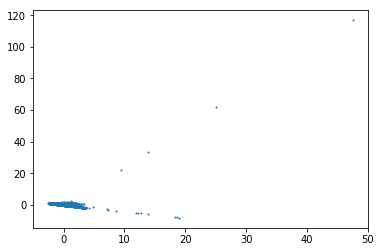

In [34]:
# 1.降维查看原始数据分布
pca_2 = PCA(n_components=2,whiten=True).fit(x_train_baseline_stand)
base_pca_data = pca_2.transform(x_train_baseline_stand)
plt.scatter(base_pca_data[:,0], base_pca_data[:,1], s=1)
# 不需要做异常点去除
data_ad = x_train_baseline_stand

In [35]:
# 2.异常点检测
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
def anomaly_detection(raw_data, apply_data, name, outliers_fraction=0.2):
    '''
    描述:
    参数：
        name: 选用的算法名字
        apply_data:对apply_data去除掉异常值,apply_data是标准化之后的样本
        outliers_fraction：表示异常点的比例    
    '''
    anomaly_algorithms =  {
        "Robust covariance": EllipticEnvelope(contamination=outliers_fraction), # 速度太慢
        "One-Class SVM": svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", # 只能单核运行
                                          gamma=0.1),
        "Isolation Forest": IsolationForest(behaviour='new',
                                             contamination=outliers_fraction,
                                             max_features=0.8, 
                                             random_state=2018),
        "Local Outlier Factor": LocalOutlierFactor(n_neighbors=35, 
                                                   contamination=outliers_fraction)}


    algorithm = anomaly_algorithms[name]
    print(name)
    if name == "Local Outlier Factor":
        y_pred = algorithm.fit_predict(raw_data)
    else:
        y_pred = algorithm.fit(raw_data).predict(raw_data)
    print('number of anomalys:',np.sum(y_pred==-1))
    pca = PCA(n_components=2,whiten=True).fit(x_train_baseline_stand)
    data_pca = pca_2.transform(raw_data)
#     plt.figure(figsize=(20,10))
    colors_arr = np.ones(y_pred.shape[0])
    base_line = data_pca[y_pred!=-1] 
    anomaly = data_pca[y_pred==-1] 
    plt.scatter(base_line[:,0], base_line[:,1], s=3, c='b')
    plt.scatter(anomaly[:,0], anomaly[:,1], s=3, c='r')
    return raw_data[y_pred!=-1].copy(), apply_data[y_pred!=-1]

Isolation Forest
number of anomalys: 1200


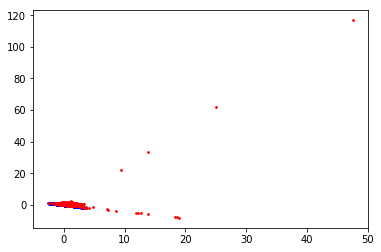

In [36]:
# anomaly_detection(x_train_baseline_stand, "Robust covariance", 0.2) 
# anomaly_detection(x_train_baseline_stand, "One-Class SVM", 0.2) 
data_ad,  x_train_baseline_ad = anomaly_detection(x_train_baseline_stand, x_train_baseline, "Isolation Forest", 0.05)
# data_ad, x_train_baseline_ad = anomaly_detection(data_ad, x_train_baseline_ad, "Isolation Forest", 0.02)
# data_ad, x_train_baseline_ad = anomaly_detection(data_ad, x_train_baseline_ad, "Isolation Forest", 0.01)

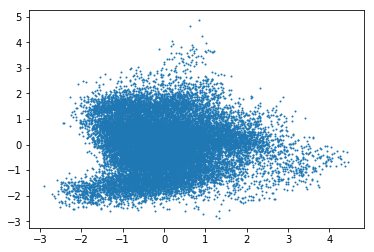

In [37]:
# 3.降维查看异常点去除效果
pca_2 = PCA(n_components=2,whiten=True).fit(data_ad)
data_ad_pca = pca_2.transform(data_ad)
plt.scatter(data_ad_pca[:,0], data_ad_pca[:,1], s=1)

In [38]:
# 基于data_ad,重新stand_scale
x_train_baseline_stand,scaler = standard_scale(x_train_baseline_ad)
joblib.dump(scaler, './scaler')

['./scaler']

## 4.使用data_ad 训练HA（Health Accessment） Model 

In [39]:
# pca and T2
import joblib
import os
from sklearn.decomposition import PCA
def dimension_reduction(x,whiten=True):
    pca = PCA(n_components=0.95,whiten=whiten).fit(x)
    return pca

def cal_T2(data,pca):
    T2=[]
    projected_data = pca.transform(data)
    eigenvalue_matrix = np.mat(np.diag(pca.singular_values_ ))
    for x in projected_data:
        tmp = np.mat(x)*np.linalg.inv(eigenvalue_matrix)*np.mat(x).T
        T2.append(tmp[0,0])
    return T2
      
# 使用归一化的、去除了异常值的健康数据
pca = dimension_reduction(data_ad.values,whiten=True)
if not os.path.exists('model'):
    os.mkdir('./model')
# 保存pca模型
joblib.dump(pca,'./model/pca_1XX')

['./model/pca_1XX']

## 5.健康分查看





In [40]:
def load_train(train_no=1, use_cols=[]):
    input_dir = '../../2.1preprocess_train_data/9.select_features/train_data/'
    train = joblib.load(input_dir+'train_0%d.lz4'%train_no) 
    y_train = train[['RULR']]
    x_train = train[use_cols]
    return x_train, y_train

x_train_01, y_train_01 = load_train(1, use_cols)
x_train_02, y_train_02 = load_train(2, use_cols)
x_train_03, y_train_03 = load_train(3, use_cols)

In [45]:
def gen_T2_df(data_stand, pca):
    T2 = cal_T2(data_stand,pca)
    T2 = pd.DataFrame(data=T2,columns=['T2'], index=data_stand.index)
    # plt.figure(figsize=(10,8))
    # T2.plot()
    # T2_ewm = T2.ewm(alpha=0.4).mean()
    # T2_ewm.plot()
    return T2

In [46]:
data_stand = standard_scale_new(x_train_01,scaler)
data_stand.shape

(103367, 17)

In [47]:
T2 = gen_T2_df(data_stand, pca)

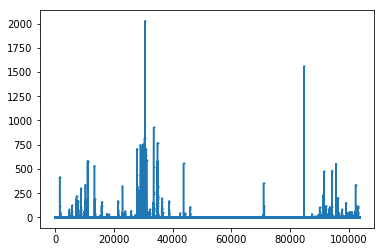

In [48]:
plt.plot(T2)
plt.scatter(range(len(T2)), T2, s=1)

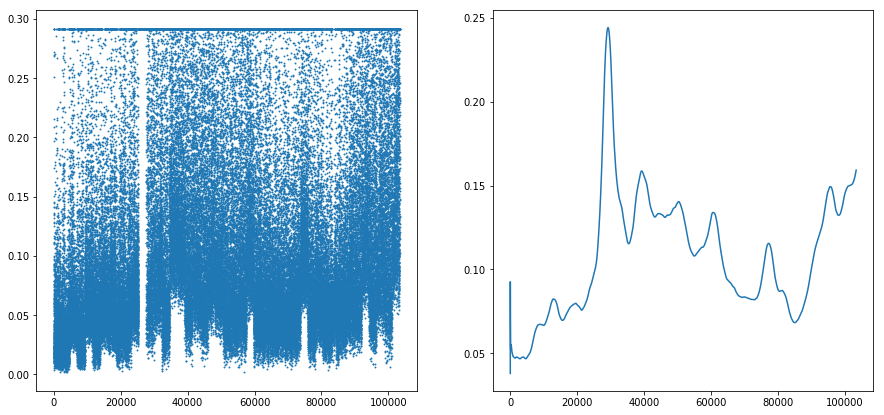

In [49]:
def box_filter(x):
    '''
    描述：
        箱线图去异常值，x为array
    '''
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x,75)
    iqr = q3 - q1
    low_bound = q1 - 1.5*iqr
    up_bound = q3 + 1.5*iqr
    x[x<low_bound] = low_bound
    x[x>up_bound] = up_bound
    return x 

plt.figure(figsize=(15,7))
plt.subplot(121)
T2_ad = box_filter(T2.values.ravel())
plt.scatter(range(len(T2_ad)),T2_ad, s=0.8)

plt.subplot(122)
T2_ad_rolled = pd.Series(T2_ad).rolling(window=5000, min_periods=1, center=False, win_type ='triang').mean()
T2_ad_rolled.plot()

# 效果不理想的原因 
没有利用刀具的规划路径x,y,z , 导致不同工况下的数据不具备可比性， 因此使用计算偏离健康数据的健康程度的方法可能不适用。